<a href="https://colab.research.google.com/github/leolani/cltl-face-all/blob/master/4.ERC-MELD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# We will train our simples models here together.

We'll start with the small pre-defined dataset

## Clone the repo, download the necessary files, etc.

In [ ]:
%cd /content
!git clone https://github.com/leolani/cltl-face-all
!cd cltl-face-all/ && pip install .
!pip install omegaconf==2.0.5
!pip install tqdm av

# Download the annotations and stuff
!wget https://raw.githubusercontent.com/declare-lab/MELD/master/data/MELD/train_sent_emo.csv
!wget https://raw.githubusercontent.com/leolani/cltl-face-all/master/examples/smaller-datatsets-jsons/dataset-small.json
!wget https://raw.githubusercontent.com/leolani/cltl-face-all/master/examples/smaller-datatsets-jsons/dataset-medium.json
!wget https://raw.githubusercontent.com/leolani/cltl-face-all/master/examples/smaller-datatsets-jsons/dataset-large.json
!wget https://raw.githubusercontent.com/leolani/cltl-face-all/master/examples/smaller-datatsets-jsons/datasets.json

!gdown --id 1-2LeHC_5Cm2gWWT6vBrVhp8jorbjkN1_
!unzip visual-features.zip
!rm visual-features.zip

!gdown --id 16ck7plW9v9eSHGCs5wuB2AhhufPRt3Wi
!unzip smaller-dataset.zip
!rm smaller-dataset.zip

!ls smaller-dataset/  |  wc -l
!ls visual-features | wc -l

import json

with open('datasets.json', 'r') as stream:
    datasets = json.load(stream)

datasets = datasets['large']

## Randomly select a video and play it



In [13]:
from glob import glob
import random
import os
import json
import numpy as np
import av
import matplotlib.pyplot as plt
import cv2
import random
from IPython.display import HTML
from base64 import b64encode

VISUAL_FEATURES_PATH = 'visual-features/'
VIDEOS_PATH = "smaller-dataset/"

diautt = random.choice([foo for foo, bar in datasets['train'].items()])
annot = datasets['train'][diautt]
features_path = os.path.join(VISUAL_FEATURES_PATH, diautt) + '.npy'

features = np.load(features_path, allow_pickle=True)
# below line is necessary since the saved file is actually a dictionary.
features = features.item()

vid_path = os.path.join(VIDEOS_PATH, diautt) +  '.mp4'
container = av.open(vid_path)

print(vid_path)
print(annot)

frames = {}
for frame in container.decode(video=0):
    idx = frame.index
    numpy_RGB = np.array(frame.to_image())
    frames[idx] = numpy_RGB

assert np.abs(len(frames) - len(features)) <= 1

mp4 = open(vid_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=1280 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

smaller-dataset/dia528_utt1.mp4
{'SrNo': '5227', 'Utterance': 'Okay, Joey Tribbiani invited me back to his apartment, now does he do this with a lot of girls?', 'Speaker': 'Rachel', 'Emotion': 'neutral', 'Sentiment': 'neutral', 'Dialogue_ID': '528', 'Utterance_ID': '1', 'Season': '6', 'Episode': '15', 'StartTime': '00:17:10,863', 'EndTime': '00:17:20,288'}


## Randomly select a frame and check it

59


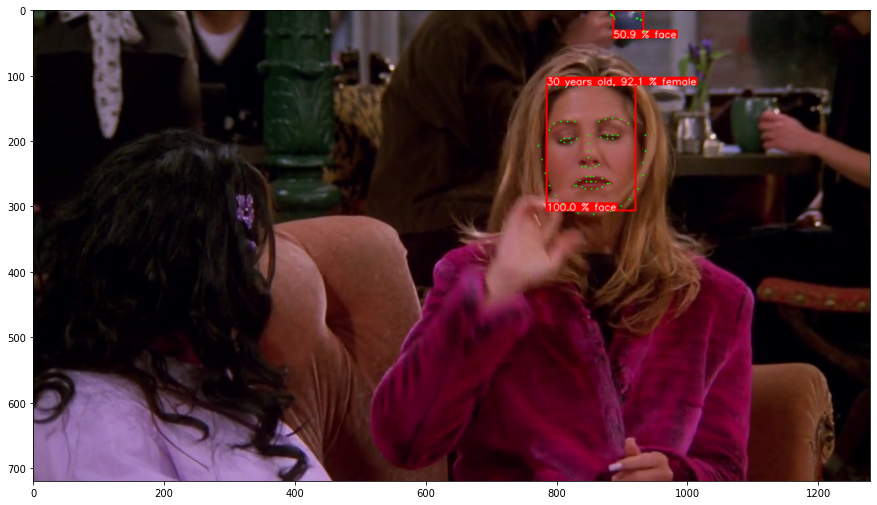

SrNo 	 5227
Utterance 	 Okay, Joey Tribbiani invited me back to his apartment, now does he do this with a lot of girls?
Speaker 	 Rachel
Emotion 	 neutral
Sentiment 	 neutral
Dialogue_ID 	 528
Utterance_ID 	 1
Season 	 6
Episode 	 15
StartTime 	 00:17:10,863
EndTime 	 00:17:20,288


In [14]:
def draw_label(image, point, label, font=cv2.FONT_HERSHEY_SIMPLEX,
               font_scale=0.8, thickness=1):
    size = cv2.getTextSize(label, font, font_scale, thickness)[0]
    x, y = point
    cv2.rectangle(image, (x, y - size[1]), (x + size[0], y), (255, 0, 0), cv2.FILLED)
    cv2.putText(image, label, point, font, font_scale, (255, 255, 255), thickness, lineType=cv2.LINE_AA)
    
idx = random.choice(list(frames.keys()))
img = frames[idx]
print(idx)

feature = features[idx]

for feat in feature:
    bbox = feat['bbox']
    landmark = feat['landmark']
    age = feat['age']
    gender = feat['gender']
    embedding = feat['embedding']
    # face = feat['face']

    x1, y1, x2, y2, prob = bbox
    
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

    label = f"{str(round(prob*100, 1))} % face"
    draw_label(img, (x1, y2), label, font_scale=0.5, thickness=1)

    for lm in landmark:
        cv2.circle(img, (int(lm[0]), int(lm[1])), 1, (0,255,0), -1)

    label = f"{int(age)} years old, {str(round(gender*100, 1))} % female"
    draw_label(img, (x1, y1), label, font_scale=0.5, thickness=1)
    
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.show()

for key, val in annot.items():
    print(key, '\t', val)

## The datasets structure

It comes with three different sizes.

In [2]:
datasets.keys()

dict_keys(['train', 'dev', 'test'])

In [3]:
for key, val in datasets.items():
    print(key, len(val))

train 584
dev 97
test 108


## Let's see how the data actually looks like

run the below cell.

In [4]:
datasets['train']['dia1000_utt0']

{'Dialogue_ID': '1000',
 'Emotion': 'disgust',
 'EndTime': '00:06:49,783',
 'Episode': '3',
 'Season': '2',
 'Sentiment': 'negative',
 'Speaker': 'Monica',
 'SrNo': '10029',
 'StartTime': '00:06:45,780',
 'Utterance': 'Would you look at this dump? He hated us. This is his final revenge!',
 'Utterance_ID': '0'}

## Let's check out the data distributions.

In [5]:
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter

def count2ratio(counts):
    total_counts = sum([val for key, val in counts.items()])

    return {key: round(val/total_counts, 3) for key, val in counts.items()}

for key, val in datasets.items():
    sentiments = []
    emotions = []
    speakers = []

    for diautt, annot in val.items():
        sentiments.append(annot['Sentiment'])
        emotions.append(annot['Emotion'])
        speakers.append(annot['Speaker'])

    sentiments = dict(Counter(sentiments))
    emotions = dict(Counter(emotions))
    speakers = dict(Counter(speakers))

    sentiments = count2ratio(sentiments)
    emotions = count2ratio(emotions)
    speakers = count2ratio(speakers)

    print(key, 'sentiments', sentiments)
    print(key, 'emotions', emotions)
    print(key, 'speakers', sentiments)
    print()

train sentiments {'negative': 0.274, 'neutral': 0.473, 'positive': 0.253}
train emotions {'disgust': 0.026, 'anger': 0.091, 'neutral': 0.473, 'sadness': 0.082, 'joy': 0.182, 'surprise': 0.125, 'fear': 0.022}
train speakers {'negative': 0.274, 'neutral': 0.473, 'positive': 0.253}

dev sentiments {'positive': 0.206, 'neutral': 0.557, 'negative': 0.237}
dev emotions {'surprise': 0.072, 'neutral': 0.557, 'joy': 0.175, 'disgust': 0.052, 'anger': 0.072, 'fear': 0.021, 'sadness': 0.052}
dev speakers {'positive': 0.206, 'neutral': 0.557, 'negative': 0.237}

test sentiments {'negative': 0.259, 'neutral': 0.509, 'positive': 0.231}
test emotions {'surprise': 0.167, 'neutral': 0.509, 'anger': 0.056, 'sadness': 0.12, 'joy': 0.13, 'fear': 0.009, 'disgust': 0.009}
test speakers {'negative': 0.259, 'neutral': 0.509, 'positive': 0.231}



When it comes to the emotion classes, you can see that the label `neutral` accounts for nearly half of the instances. **This means that if your emotion classifier performs less than the accuracy of 50%, you are doing something wrong.**



## TODO1:

Extract viasual features or train a classifier. Each video (utterance) should result in a fixed-size vector. This should be done by Tae and Wes.

In [6]:
import os
from glob import glob
import numpy as np
from cltl_face_all.arcface import calc_angle_distance
from tqdm.notebook import tqdm


predefined_faces_= glob(os.path.join('./cltl-face-all/your-faces/*/*.npy'))
predefined_faces = {}

for path in predefined_faces_:
    name = path.split('/')[-2]
    predefined_faces[name] = np.load(path)

vecs = {}
THRESHOLDS = {'face': 0.9, 'angle': 1.15}

for DATASET in tqdm(['train', 'dev', 'test']):
    vecs[DATASET] = {}
    for diautt, annot in datasets[DATASET].items():
        vecs[DATASET][diautt] = {}
        speaker = annot['Speaker']

        visual_features = np.load(f'visual-features/{diautt}.npy', \
                                    allow_pickle=True).item()

        for frame, features in visual_features.items():
            vecs[DATASET][diautt][frame] = None
            # Assume that there is only one unique face per frame.
            for feat in features:
                age = feat['age']
                gender = feat['gender']
                bbox = feat['bbox']
                embedding = feat['embedding']
                landmark = feat['landmark']

                if bbox[-1] < THRESHOLDS['face']:
                    continue

                if speaker not in list(predefined_faces.keys()):
                    continue

                embedding.reshape(1, 512)

                dists = {key: calc_angle_distance(embedding, val) for key, val \
                            in predefined_faces.items()}

                if dists[speaker] < THRESHOLDS['angle']:
                    vecs[DATASET][diautt][frame] = landmark


In [7]:
vecs_with_speaker = {}

for DATASET in tqdm(['train', 'dev', 'test']):
    vecs_with_speaker[DATASET] = {}

    print(f"{len(vecs[DATASET])} videos in {DATASET}")
    for diautt, frame_landmarks in vecs[DATASET].items():
        with_speaker = [lm for lm in frame_landmarks.values() if lm is not None]
        if len(with_speaker) > 0:
            vecs_with_speaker[DATASET][diautt] = with_speaker

    print(f"{len(vecs_with_speaker[DATASET])} videos in {DATASET}, after removing the utterances without the speaker face")
    print(f"the ratio is {len(vecs_with_speaker[DATASET]) / len(vecs[DATASET])}")
    print()

584 videos in train
472 videos in train, after removing the utterances without the speaker face
the ratio is 0.8082191780821918

97 videos in dev
79 videos in dev, after removing the utterances without the speaker face
the ratio is 0.8144329896907216

108 videos in test
93 videos in test, after removing the utterances without the speaker face
the ratio is 0.8611111111111112




In [9]:
X = {}
y = {}
emotion2num = {'anger': 0,
               'disgust': 1,
               'fear': 2,
               'joy': 3,
               'neutral': 4,
               'sadness': 5, 
               'surprise': 6}
num2onehot = {0: np.array([1, 0, 0, 0, 0, 0, 0]),
              1: np.array([0, 1, 0, 0, 0, 0, 0]),
              2: np.array([0, 0, 1, 0, 0, 0, 0]),
              3: np.array([0, 0, 0, 1, 0, 0, 0]),
              4: np.array([0, 0, 0, 0, 1, 0, 0]),
              5: np.array([0, 0, 0, 0, 0, 1, 0]),
              6: np.array([0, 0, 0, 0, 0, 0, 1])}

for DATATYPE in ['train', 'dev', 'test']:
    X[DATATYPE] = []
    y[DATATYPE] = []
    for diautt, landmarks in vecs_with_speaker[DATATYPE].items():
        label = datasets[DATATYPE][diautt]['Emotion']
        X[DATATYPE].append(landmarks)
        y[DATATYPE].append(num2onehot[emotion2num[label]])

## TODO2:

Extract text features  or train a classifier. Each video (utterance) should result in a fixed-size vector. This should be done by Nihat and Zeynep.

In [ ]:
#DO IT

## TODO3:

Extract audio features  or train a classifier. Each video (utterance) should result in a fixed-size vector. This should be done by Vivian.

In [ ]:
#DO IT

## TOOD4:

Concatenate the three feature vectors and/or train a simple classifier. Start simple (e.g. one-layered logistic regression). This should be done all together.

In [ ]:
#DO IT